In [1]:
import pandas as pd

# Load dataset from Kaggle
!pip install kaggle
from google.colab import files

# Upload your Kaggle API key (Download from your Kaggle account)
files.upload()

# Download dataset
!kaggle datasets download -d johnsmith88/heart-disease-dataset
!unzip heart-disease-dataset.zip

# Load data
df = pd.read_csv("heart.csv")

# Show first few rows
df.head()


Saving archive.zip to archive.zip
Dataset URL: https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset
License(s): unknown
  0% 0.00/6.18k [00:00<?, ?B/s]
100% 6.18k/6.18k [00:00<00:00, 14.0MB/s]
Archive:  heart-disease-dataset.zip
  inflating: heart.csv               


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select input features and target variable
X = df.drop(columns=['target'])  # Features
y = df['target']  # Labels

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)


In [3]:
class HeartDiseaseModel(nn.Module):
    def __init__(self, input_size):
        super(HeartDiseaseModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 2)  # 2 output classes (Disease/No Disease)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return self.softmax(x)

# Initialize model
input_size = X_train.shape[1]
model = HeartDiseaseModel(input_size)


In [4]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 50
for epoch in range(epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


Epoch [10/50], Loss: 0.5697
Epoch [20/50], Loss: 0.4621
Epoch [30/50], Loss: 0.4290
Epoch [40/50], Loss: 0.4144
Epoch [50/50], Loss: 0.4018


In [5]:
# Test the model
with torch.no_grad():
    test_outputs = model(X_test)
    _, predictions = torch.max(test_outputs, 1)

    accuracy = (predictions == y_test).sum().item() / y_test.size(0)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 85.85%


In [6]:
class ImprovedHeartDiseaseModel(nn.Module):
    def __init__(self, input_size):
        super(ImprovedHeartDiseaseModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)  # Increased neurons
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 2)  # Output layer
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return self.softmax(x)

# Initialize model
model = ImprovedHeartDiseaseModel(input_size)

# Define new optimizer with lower learning rate
optimizer = optim.Adam(model.parameters(), lr=0.005)


Epoch [10/50], Loss: 0.6740
Epoch [20/50], Loss: 0.5897
Epoch [30/50], Loss: 0.4639
Epoch [40/50], Loss: 0.4239
Epoch [50/50], Loss: 0.4032


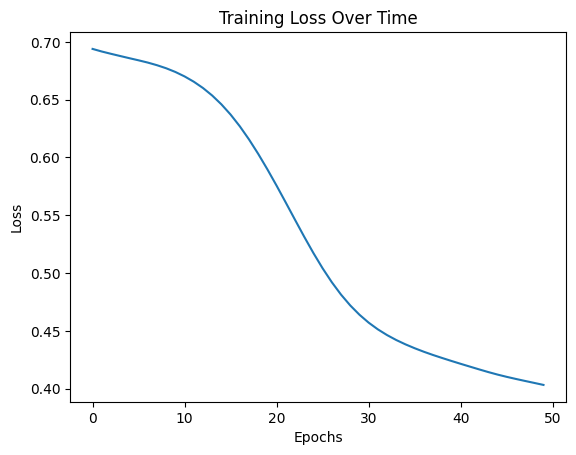

In [7]:
import matplotlib.pyplot as plt

# Store loss values for visualization
loss_values = []

epochs = 50
for epoch in range(epochs):
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_values.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Plot loss graph
plt.plot(range(epochs), loss_values)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.show()


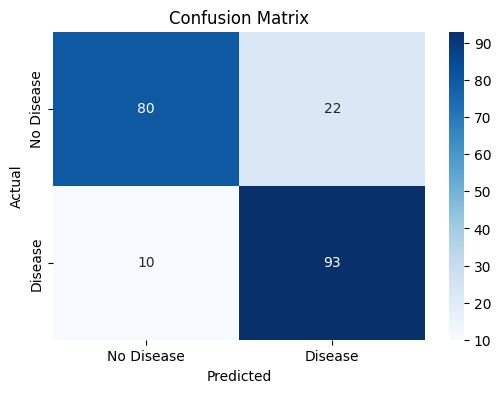

              precision    recall  f1-score   support

           0       0.89      0.78      0.83       102
           1       0.81      0.90      0.85       103

    accuracy                           0.84       205
   macro avg       0.85      0.84      0.84       205
weighted avg       0.85      0.84      0.84       205



In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

with torch.no_grad():
    test_outputs = model(X_test)
    _, predictions = torch.max(test_outputs, 1)

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Disease", "Disease"], yticklabels=["No Disease", "Disease"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_test, predictions))


In [9]:
torch.save(model.state_dict(), "heart_disease_model.pth")


In [10]:
from google.colab import files

# Download the model file
files.download("heart_disease_model.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>